In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_array = cv2.imread('AffectNet/train/0/image0000006.jpg', cv2.IMREAD_GRAYSCALE)

In [3]:
image_array.shape

(773, 773)

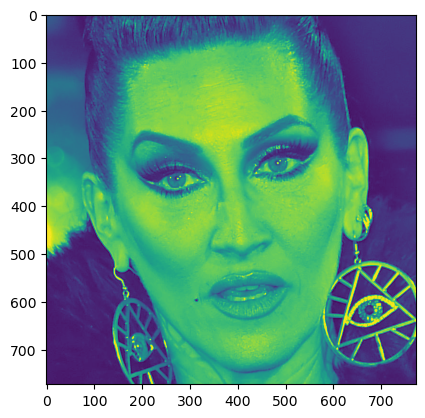

In [4]:
plt.imshow(image_array)

In [5]:
DATA_DIR = 'AffectNet/'
CATEGORIES = ['train', 'val', 'test']

In [6]:
CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7']

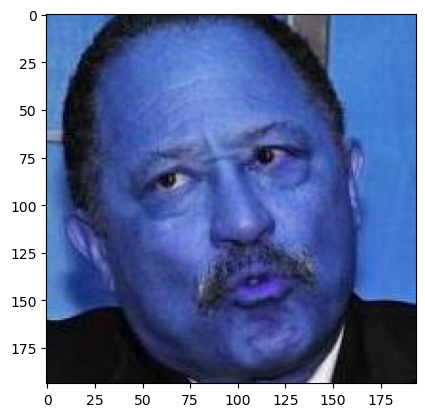

In [7]:
for categoy in CATEGORIES:
    for class_name in CLASSES:
        path = os.path.join(DATA_DIR, categoy, class_name)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            plt.imshow(img_array, cmap='gray')
            plt.show()
            break
        break
    break

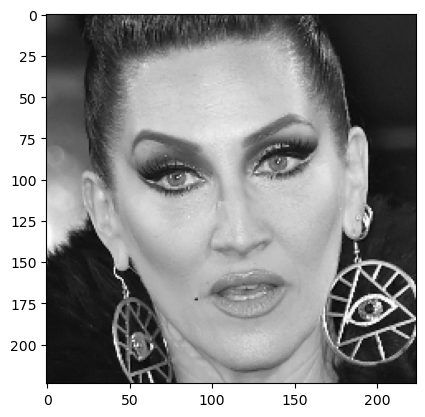

In [8]:
image_size = 224
image_array = cv2.resize(image_array, (image_size, image_size))
plt.imshow(image_array, cmap='gray')
plt.show()

In [9]:
image_array.shape

(224, 224)

# Read all the images and convertin them to array

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-28 16:04:15.702695: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 16:04:15.722382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 16:04:15.722403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 16:04:15.722407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-28 16:04:15.725860: I tensorflow/core/platform/cpu_feature_g

In [11]:
def data_generator(data_dir, image_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_gen = datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
    )

    val_gen = datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
    )

    test_gen = datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse'
    )

    return train_gen, val_gen, test_gen

In [12]:
image_size = (224, 224)

In [13]:
batch_size = 32

In [14]:
train_gen, val_gen, test_gen = data_generator(DATA_DIR, image_size=image_size, batch_size=batch_size)

Found 37553 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 3200 images belonging to 8 classes.


In [15]:
test_gen.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7}

# Deep learning model for training - Transfer Learning

In [16]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation # type: ignore
from tensorflow.keras.models import Model  # type: ignore

In [17]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-28 16:04:17.021695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-28 16:04:17.056402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-28 16:04:17.056503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-06-28 16:04:17.067061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-28 16:04:17.067183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-28 16:04:17.067233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [19]:
base_input = model.input

In [20]:
base_input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [21]:
base_output = model.layers[-2].output

In [22]:
x = base_output
x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(64)(x)
x = Activation('relu')(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

In [23]:
new_model = Model(inputs=base_input, outputs=predictions)

In [24]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [25]:
new_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.0001))

In [26]:
# Huấn luyện mô hình

new_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    epochs=100


    
)


Epoch 1/100


2024-06-28 16:04:26.845009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-06-28 16:04:27.728705: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd1c4065f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-28 16:04:27.728727: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-06-28 16:04:27.731231: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-28 16:04:27.779541: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1173/1173 [==============================] - 192s 154ms/step - loss: 1.6994 - accuracy: 0.3729 - val_loss: 1.7531 - val_accuracy: 0.4050
Epoch 2/100
1173/1173 [==============================] - 174s 148ms/step - loss: 1.3460 - accuracy: 0.4953 - val_loss: 1.4504 - val_accuracy: 0.4900
Epoch 3/100
1173/1173 [==============================] - 176s 150ms/step - loss: 1.2498 - accuracy: 0.5336 - val_loss: 1.4291 - val_accuracy: 0.4875
Epoch 4/100
1173/1173 [==============================] - 175s 149ms/step - loss: 1.1867 - accuracy: 0.5597 - val_loss: 1.3425 - val_accuracy: 0.5200
Epoch 5/100
1173/1173 [==============================] - 175s 149ms/step - loss: 1.1382 - accuracy: 0.5795 - val_loss: 1.3502 - val_accuracy: 0.5150
Epoch 6/100
1173/1173 [==============================] - 175s 149ms/step - loss: 1.1002 - accuracy: 0.5894 - val_loss: 1.2795 - val_accuracy: 0.5650
Epoch 7/100
1173/1173 [==============================] - 175s 149ms/step - loss: 1.0647 - accuracy: 0.6034 - val_loss:

In [27]:
# save the model
new_model.save('emotion_model.h5')

/home/alexender/anaconda3/envs/emotion-env/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# show predictions
predictions = new_model.predict(test_gen)

100/100 [==============================] - 17s 162ms/step


In [29]:
predictions

array([[9.6265000e-01, 9.7504054e-04, 3.3851236e-02, ..., 2.5459987e-04,
        6.1647524e-06, 7.3727319e-04],
       [1.4142309e-02, 4.9831415e-05, 1.1903829e-02, ..., 3.3093736e-02,
        1.0081340e-01, 7.5369024e-01],
       [3.1386871e-02, 5.3618511e-05, 3.7349685e-06, ..., 1.0348396e-06,
        2.3309797e-06, 9.6852094e-01],
       ...,
       [9.0673054e-04, 2.6191954e-06, 2.5977360e-07, ..., 7.3370154e-07,
        3.4334473e-04, 1.1759264e-08],
       [7.1915936e-01, 2.5838343e-04, 3.2429740e-02, ..., 3.5080211e-03,
        1.7056414e-03, 1.9376838e-03],
       [1.8672719e-09, 3.1000283e-10, 1.4332089e-09, ..., 3.5891645e-08,
        7.6561162e-12, 1.3224365e-08]], dtype=float32)

In [31]:
%pip install scikit-learn
%pip install seaborn

/bin/bash: /home/alexender/anaconda3/envs/emotion-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached scikit_learn-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/alexender/anaconda3/envs/emotion-env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.me

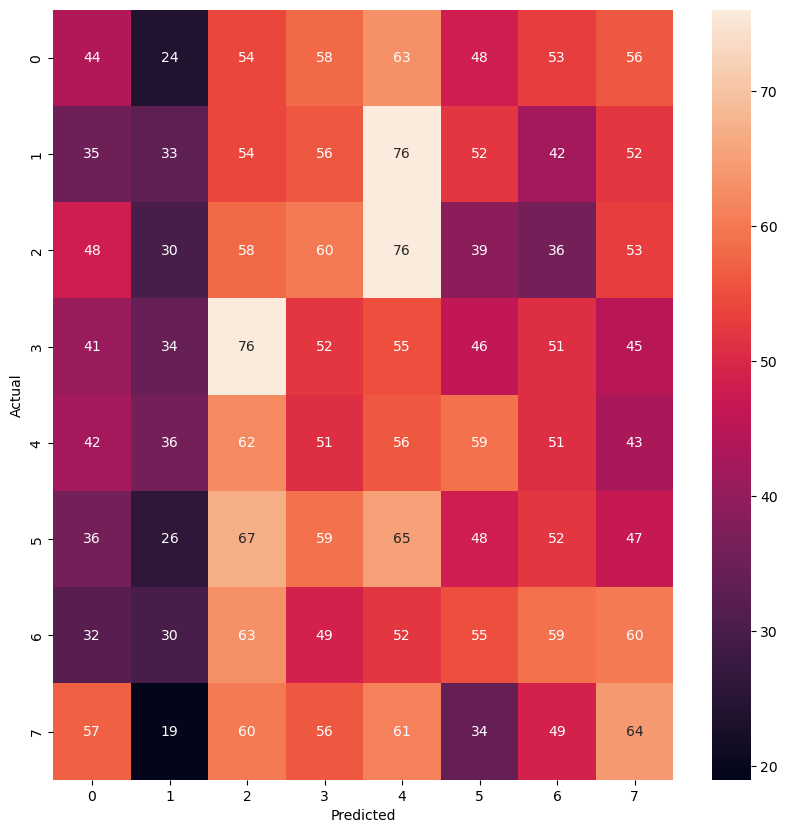

In [32]:
# draw confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


KeyError: 'accuracy'

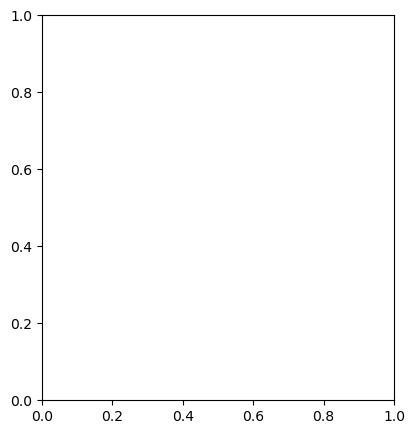

In [33]:
# show loss and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.plot(new_model.history.history['accuracy'], label='accuracy')

plt.plot(new_model.history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(new_model.history.history['loss'], label='loss')

plt.plot(new_model.history.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
new_model.history.history

{}

In [43]:
#test on real image
import cv2

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image) / 255.0
    return image



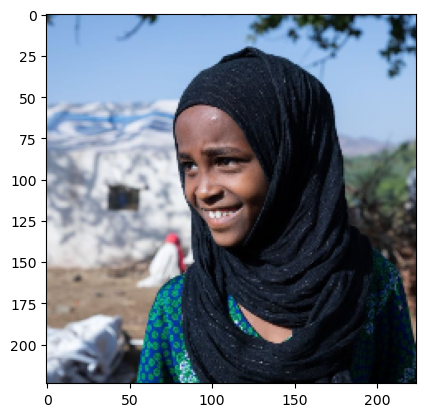

In [44]:
image = load_image('image.png')

plt.imshow(image)

In [45]:

image = np.expand_dims(image, axis=0)
image.shape

(1, 224, 224, 3)

In [46]:
# predict
predictions = new_model.predict(image)
predictions

1/1 [==============================] - 0s 346ms/step


array([[1.6281361e-02, 5.4506157e-03, 1.4147827e-04, 9.0817831e-02,
        2.6699113e-02, 1.5823714e-01, 1.7559689e-02, 6.8481278e-01]],
      dtype=float32)

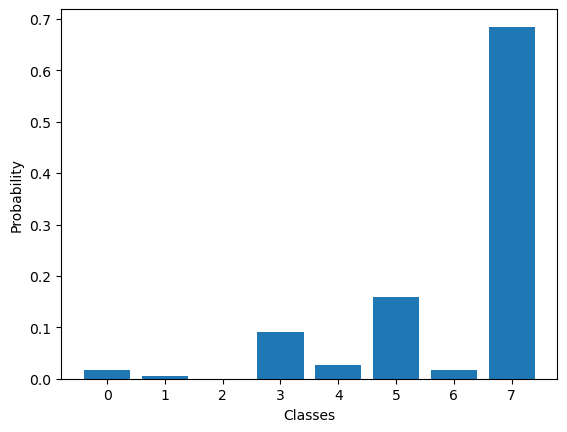

In [48]:
# draw the result
plt.bar(CLASSES, predictions[0])
plt.ylabel('Probability')
plt.xlabel('Classes')
plt.show()



1/1 [==============================] - 0s 11ms/step


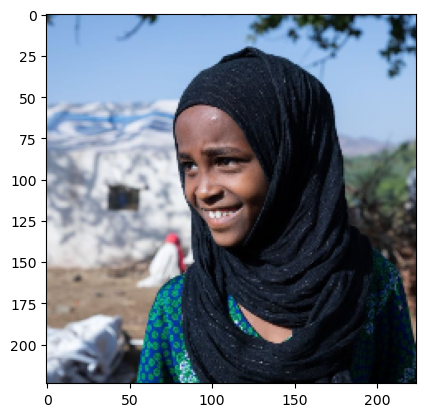

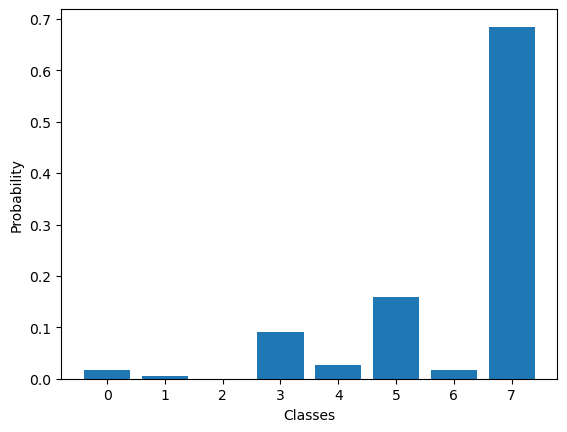

1/1 [==============================] - 0s 11ms/step


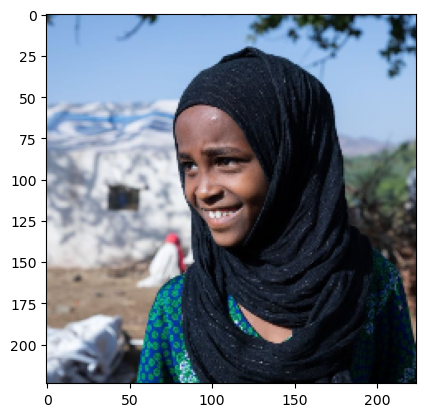

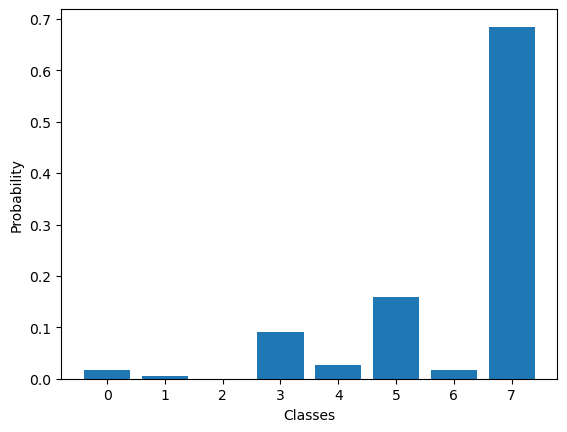

1/1 [==============================] - 0s 17ms/step


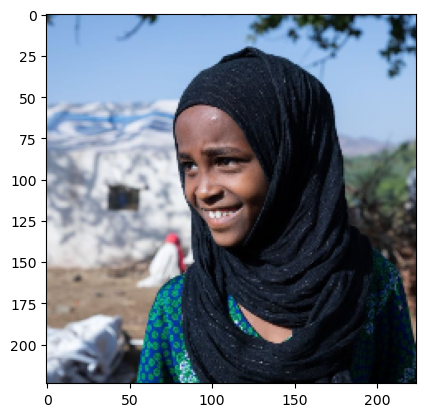

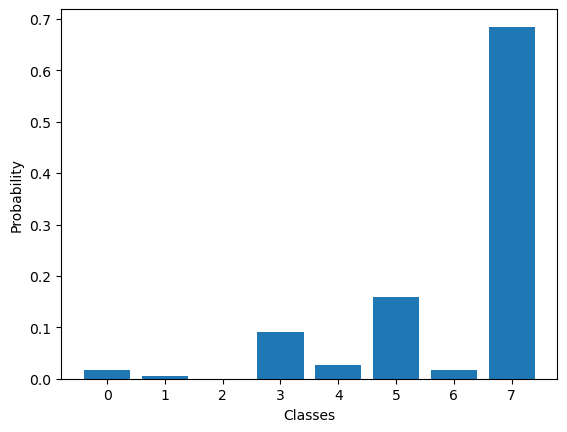

1/1 [==============================] - 0s 12ms/step


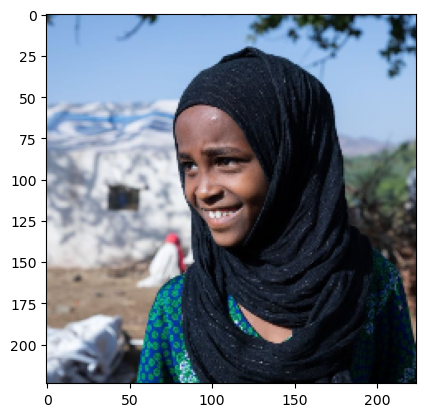

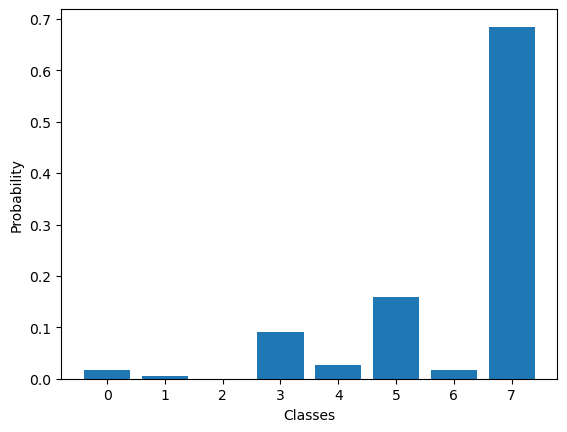

1/1 [==============================] - 0s 13ms/step


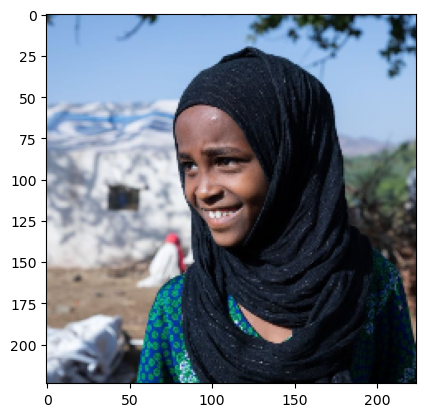

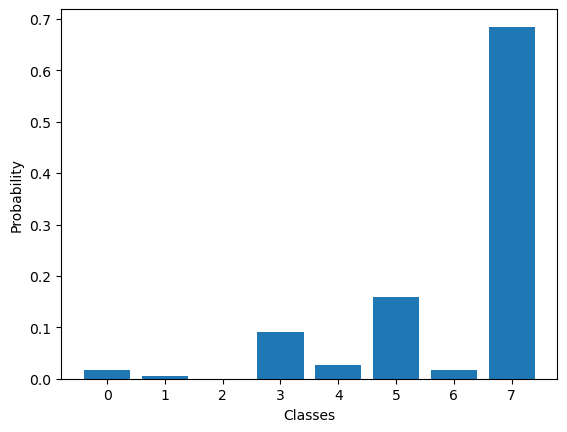

In [50]:
# crop image to face only

for i in range(1, 6):
    image = cv2.imread(f'image.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    predictions = new_model.predict(image)

    plt.imshow(image[0])
    plt.show()

    plt.bar(CLASSES, predictions[0])
    plt.ylabel('Probability')
    plt.xlabel('Classes')
    plt.show()
